In [28]:
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings

# Suppress potential warnings from KMeans
warnings.filterwarnings('ignore', module='sklearn.cluster')

### Read dataset

In [ ]:
file_path = Path('../data/processed/final_Customer-Churn-Dataset.csv')

try:
    df = pd.read_csv(file_path)
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn,AverageMonthlyCharge
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No,29.850000
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,One year,No,Mailed check,56.95,1889.50,0,0,No,55.573529
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes,54.075000
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No,40.905556
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes,75.825000


In [9]:
# Select features for segmentation
# We'll use numerical features and potentially some encoded categorical features later
features_for_segmentation = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AverageMonthlyCharge', 'SeniorCitizen', 'numAdminTickets', 'numTechTickets']

In [10]:
# Select the relevant columns
X = df[features_for_segmentation]

In [11]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Determine the optimal number of clusters using the Elbow method (as a common approach)
# We'll try a range of cluster numbers and look for the 'elbow' point
inertia = []
range_of_clusters = range(1, 11)

for num_clusters in range_of_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10) # Added n_init
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

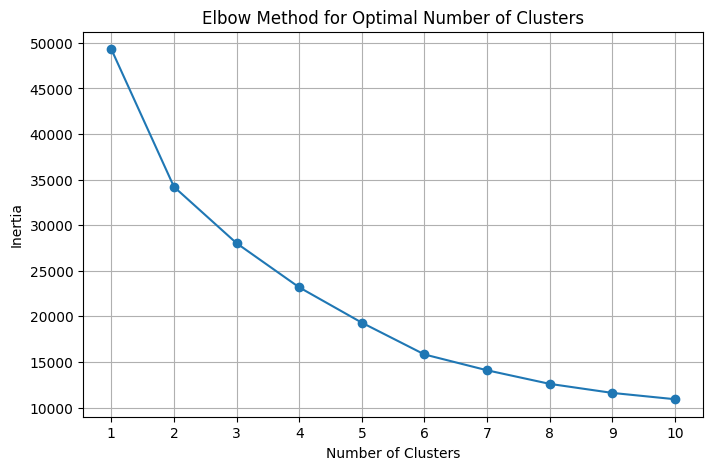

In [15]:
# Plot the Elbow method graph
plt.figure(figsize=(8, 5))
plt.plot(range_of_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range_of_clusters)
plt.grid(True)
plt.show()

In [16]:
# Based on the elbow method, let's choose a number of clusters (e.g., 4 as a common starting point before seeing the plot)
# You can adjust the number of clusters after examining the plot
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Added n_init

In [17]:
# Fit KMeans and add the cluster labels to the DataFrame
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [18]:
# Display the first few rows with the cluster labels
display(df[['customerID'] + features_for_segmentation + ['Cluster']].head())

,customerID,tenure,MonthlyCharges,TotalCharges,AverageMonthlyCharge,SeniorCitizen,numAdminTickets,numTechTickets,Cluster
0,7590-VHVEG,1,29.85,29.85,29.850000,0,0,0,3
1,5575-GNVDE,34,56.95,1889.50,55.573529,0,0,0,3
2,3668-QPYBK,2,53.85,108.15,54.075000,0,0,0,0
3,7795-CFOCW,45,42.30,1840.75,40.905556,0,0,3,3
4,9237-HQITU,2,70.70,151.65,75.825000,0,0,0,0


In [19]:
# Analyze the characteristics of each cluster
print("\nAnalyzing cluster characteristics:")
display(df.groupby('Cluster')[features_for_segmentation].mean())


Analyzing cluster characteristics:


,tenure,MonthlyCharges,TotalCharges,AverageMonthlyCharge,SeniorCitizen,numAdminTickets,numTechTickets
Cluster,,,,,,,
0,14.211347,78.436877,1123.206691,78.450082,0.249026,0.547856,0.188393
1,59.630918,89.073360,5308.391129,89.121438,0.181403,0.532801,0.064461
2,51.611570,91.395248,4714.229752,91.519659,0.295455,0.469008,4.539256
3,26.296756,29.885843,757.212585,29.636729,0.042451,0.482980,0.084101


In [20]:
# Analyze churn rate within each cluster
print("\nAnalyzing churn rate per cluster:")
display(df.groupby('Cluster')['Churn'].value_counts(normalize=True).unstack())


Analyzing churn rate per cluster:


Churn,No,Yes
Cluster,,
0,0.534430,0.465570
1,0.978323,0.021677
2,0.233471,0.766529
3,0.845815,0.154185


### Visualizing clusters based on key features

In [21]:
# Add cluster labels to the scaled data for plotting
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_segmentation)
X_scaled_df['Cluster'] = df['Cluster'] # Assuming 'Cluster' column was added to df

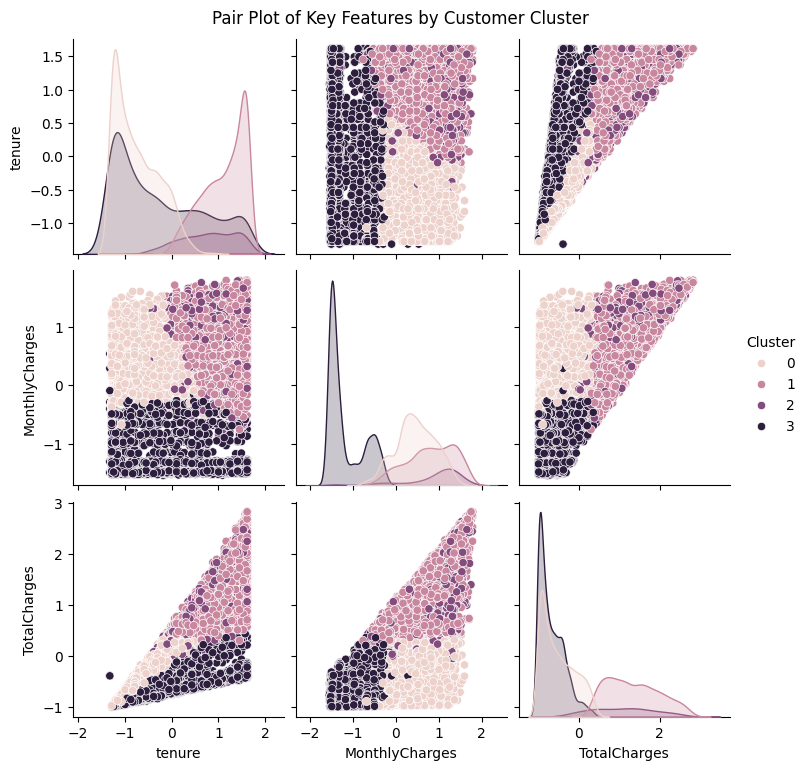

In [22]:
# Plot pairs of key features colored by cluster
# Let's select a few key features that showed good separation in the segmentation analysis
key_features_to_plot = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create a pairplot of key features, colored by Cluster
sns.pairplot(X_scaled_df[key_features_to_plot + ['Cluster']], hue='Cluster', diag_kind='kde')
plt.suptitle('Pair Plot of Key Features by Customer Cluster', y=1.02)
plt.show()

In [25]:
# Use PCA to reduce dimensionality and plot clusters in 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results and Cluster labels
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = df['Cluster']

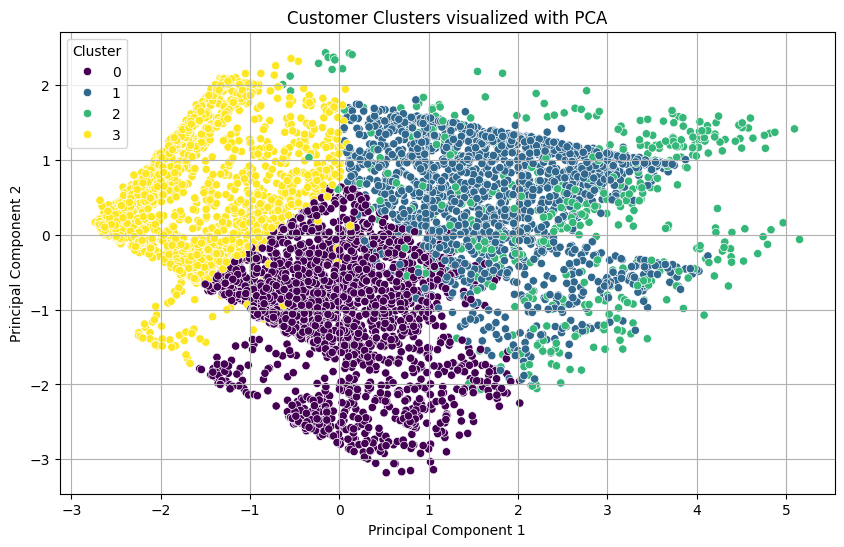

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', legend='full')
plt.title('Customer Clusters visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

### Understanding Clusters from PCA Visualization

The scatter plot visualizing the customer clusters using Principal Component Analysis (PCA) helps us understand the relationships between the clusters in a reduced, two-dimensional space (Principal Component 1 and Principal Component 2).

Here's what we can understand from this plot:

*   **Cluster Separation:** The plot shows how well-separated the identified clusters are based on the features used for segmentation. If clusters are tightly grouped and distinct from each other, it suggests that the clustering algorithm found meaningful groupings in the data. Conversely, if clusters overlap significantly, it might indicate that the features used or the number of clusters chosen are not effectively separating the customer groups.
*   **Cluster Characteristics in Reduced Space:** While the PCA components themselves don't have a direct, easily interpretable meaning in terms of the original features, their positions and spread on the plot give us a sense of the cluster characteristics in this reduced space. Clusters that are far apart in the PCA plot are significantly different from each other in terms of the combined variance captured by the principal components.
*   **Dominant Dimensions of Variation:** Principal Component 1 (PCA1) and Principal Component 2 (PCA2) represent the directions in the original feature space along which the data has the most variance. The PCA plot shows how the clusters are distributed along these dominant dimensions. For instance, a cluster located at an extreme end of PCA1 is characterized by high or low values along the combination of original features that make up PCA1.
*   **Visualizing High-Dimensional Relationships:** PCA helps to visualize relationships in a high-dimensional dataset in a way that is easier to understand visually. Even though we used 7 features for segmentation, the PCA plot allows us to see how the clusters relate to each other in a 2D projection of that space.

By examining the PCA plot alongside the analysis of cluster characteristics (mean values of features for each cluster) and churn rates per cluster, we gain a more complete picture of the customer segments and their potential implications for churn. For example, if a high-churn cluster is clearly separated in the PCA space, it visually reinforces that this group has distinct characteristics that contribute to their higher churn risk.

# Predictive Churn Modeling

In [29]:
# Separate features (X) and target variable (y)
X = df.drop(['customerID', 'Churn', 'Cluster'], axis=1) # Drop customerID, Churn, and Cluster
y = df['Churn']

In [30]:
# Encode the target variable 'Churn'
le = LabelEncoder()
y = le.fit_transform(y) # 'Yes' will likely be 1 and 'No' will be 0

In [31]:
# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include='object').columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

In [32]:
# Create a column transformer for one-hot encoding categorical features and scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any) - though in this case there are none
)

In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
# Create a pipeline with preprocessing and a Logistic Regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=42, solver='liblinear'))]) # Using liblinear solver for smaller datasets


In [35]:

# Train the model
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
# Predict on the test set
y_pred = model.predict(X_test)

In [37]:
# Evaluate the model
print("Logistic Regression Model Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Logistic Regression Model Performance:
Confusion Matrix:
 [[953  82]
 [119 255]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      1035
           1       0.76      0.68      0.72       374

    accuracy                           0.86      1409
   macro avg       0.82      0.80      0.81      1409
weighted avg       0.85      0.86      0.85      1409


Accuracy Score: 0.8573456352022711


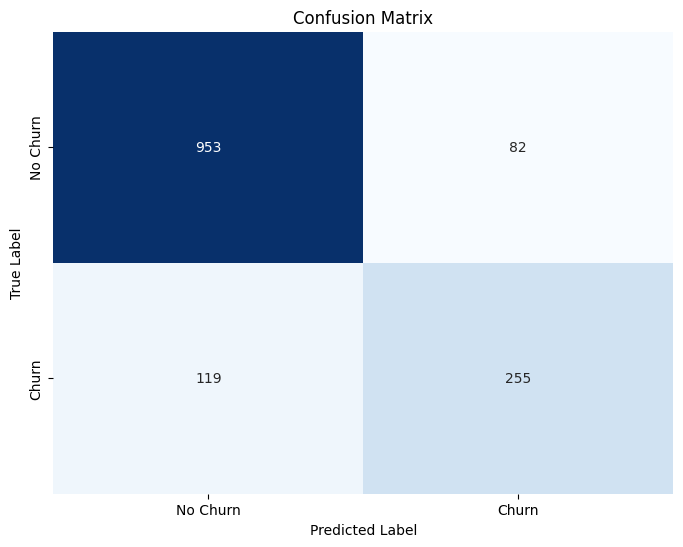

In [39]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Summary of Findings

**Customer Segmentation:**

*   K-Means clustering identified distinct customer segments with varying churn risks and characteristics.
*   Analysis of these segments revealed groups with significantly higher or lower churn rates, providing insights for targeted interventions. For instance, one cluster showed a particularly high churn rate (approximately 76.7%).

**Predictive Churn Modeling (Logistic Regression):**

*   A Logistic Regression model was developed to predict churn, achieving an overall accuracy of around 85.7%.
*   The model demonstrated a precision of approximately 76% for predicting churn and a recall of about 68%.
*   The evaluation metrics indicate that the model can identify a substantial portion of customers at risk of churning, although there is room for improvement in reducing false positives and false negatives.

# **Overall Insights and Recommendations:**

The analysis underscores that customer churn is a complex issue influenced by a combination of factors including customer tenure, service subscriptions, contract terms, and payment methods. The segmentation reveals that churn risk varies significantly across different customer groups. The predictive model provides a valuable tool for identifying at-risk customers proactively.

To reduce churn, it is recommended to:

*   Focus on retaining newer customers with shorter tenures.
*   Investigate strategies to reduce churn among customers with high monthly charges or those using Fiber Optic internet.
*   Promote longer-term contracts and the adoption of services like online security and tech support.
*   Explore reasons behind the high churn rate associated with Electronic Check payments and consider alternative payment incentives.
*   Tailor retention efforts and marketing campaigns based on the identified customer segments.

Further steps could include experimenting with other machine learning models for improved predictive performance, conducting a deeper analysis of the high-churn segment, and implementing and monitoring the impact of targeted retention strategies.

This concludes the detailed data analysis for predicting customer churn and segmenting customers.